In [1]:
import astropy
import numpy as np
import matplotlib
import scipy

from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter 

In [2]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'Black'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
file = fits.open('/Users/FRANNYPACK/Downloads/grind!/research/Data/MG_Stream_fg/the actual cube!.fits')
file[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 3551                                                  
NAXIS2  =                 4151                                                  
NAXIS3  =                  112                                                  
BUNIT   = 'K       '  /                                                         
DATE-OBS= '2020-05-09T21:46:39.0'  /                                            
TELESCOP= 'ASKAP   '  /                                                         
CRPIX1  =    1.90200000000E+03  /                                               
CDELT1  =   -1.94444444444E-03  /                                               
CRVAL1  =    2.62307458333E+01  /                                               
CTYPE1  = 'RA---SIN'  /     

In [8]:
# gets index of a specific velocity
def v_indx(v_val): # v_val must be in m/s
    v_indx = int((v_val - (4.27666857176 * 10 ** 4)) / (-9.77134909754 * 10 ** 2))
    return v_indx

In [4]:
# does the actual work of the USM

def process_usm(cc_sum, FWHM = 30.):
    
    pix_len = file[0].header['CDELT2'] * 60 # ['CDELT2'] = pixel length in deg, multiply by 60 to convert to arcmin
    FWHM30_pix = FWHM / pix_len # want FWHM to be 30 arcmin, so convert to pixels
    sigma = FWHM30_pix / (2 * np.sqrt(2 * np.log(2))) # converts from FWHM to sigma, since Gaussian filter specified by sigma
    sum_smooth = gaussian_filter(cc_sum, sigma = sigma) # does smoothing using Gaussian filter
    
    sum_USM = cc_sum - sum_smooth
    
    return sum_USM


In [5]:
# computes unsharp mask over multiple channel maps
# does 3 km/s at a time, then adds them up (so as to not wash out the small-scale structure)

def usm_mult(v_indx_min, v_indx_max, FWHM = 30., maskb = False):
    cur = v_indx_min
    num_iterations = int((v_indx_max - v_indx_min) / 3) # 3 km/s = 3 maps at a time
    tot_sum_USM = np.zeros((4151, 3551))
    
    for i in range(num_iterations + 1):
        if (i == num_iterations): # remainder of 3 that we have to integrate over
            if ((v_indx_max - v_indx_min) % 3 == 0): # nothing left to integrate over - we done!
                return tot_sum_USM
            else:
                cube_chunk = file[0].data[cur:v_indx_max, :, :]
        else: 
            cube_chunk = file[0].data[cur:cur + 3, :, :]
            
        num_v, num_y, num_x = cube_chunk.shape
        cc_sum = np.nansum(cube_chunk, axis = 0) / num_v
        if maskb:
            cc_sum = mask_border(cc_sum)
        tot_sum_USM += process_usm(cc_sum, FWHM)
        cur += 3
        
    tot_sum_USM[np.where(tot_sum_USM < 0.)] = 0. # at end so negative noise cancels out with positive noise
    return tot_sum_USM

In [6]:
# main function

def usm(v_indx_min, v_indx_max = -1, FWHM = 30., maskb = False):
    
    file = fits.open('/Users/FRANNYPACK/Downloads/grind!/research/Data/MG_Stream_fg/the actual cube!.fits') # reset
    # specific channel map
    if v_indx_max == -1:
        cc_sum = file[0].data[v_indx_min, :, :]
        sum_USM = process_usm(cc_sum)
        sum_USM[np.where(sum_USM < 0.)] = 0. # at end so negative noise cancels out with positive noise
    
    # over range of channel maps
    else:
        sum_USM = usm_mult(v_indx_min, v_indx_max, FWHM = FWHM, maskb = maskb)
        
    file = fits.open('/Users/FRANNYPACK/Downloads/grind!/research/Data/MG_Stream_fg/the actual cube!.fits') # reset
    
    return sum_USM
   

In [7]:
# displays USM

def show_usm(cd, v = '', vmin = 0, vmax = 0):
    plt.figure(figsize = (15, 9))
    plt.imshow(np.flip(np.abs(cd), axis = 0), cmap = 'magma', vmin = vmin, vmax = vmax)
    if v != '':
        plt.title(str(v) + ' km/s', fontsize = 25)
    plt.colorbar()

# INDIVIDUAL CHANNEL MAPS

In [9]:
im1 = usm(v_indx(1.15 * 10 ** 4))

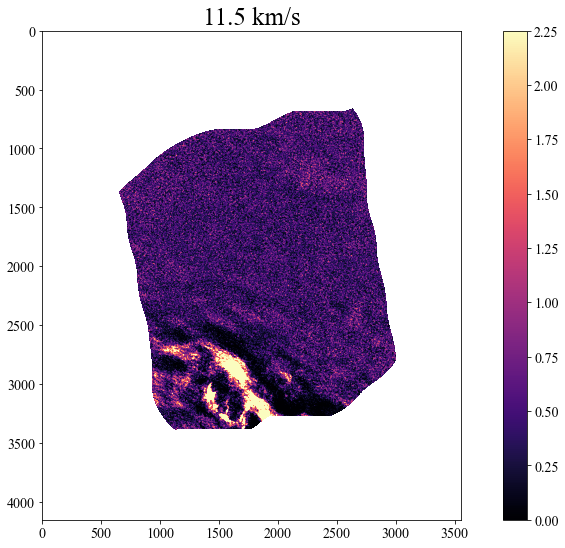

In [11]:
show_usm(im1, 11.5, vmax = 2.25)

In [13]:
im2 = usm(v_indx(7.5 * 10 ** 2))

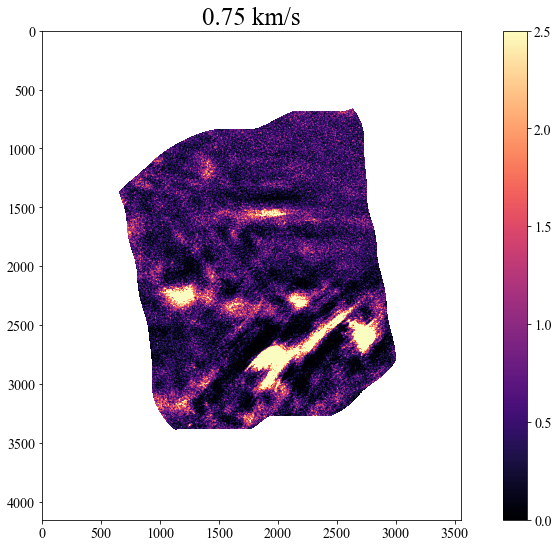

In [15]:
show_usm(im2, 0.75, vmax = 2.5)

In [16]:
im3 = usm(v_indx(-5.11 * 10 ** 3))

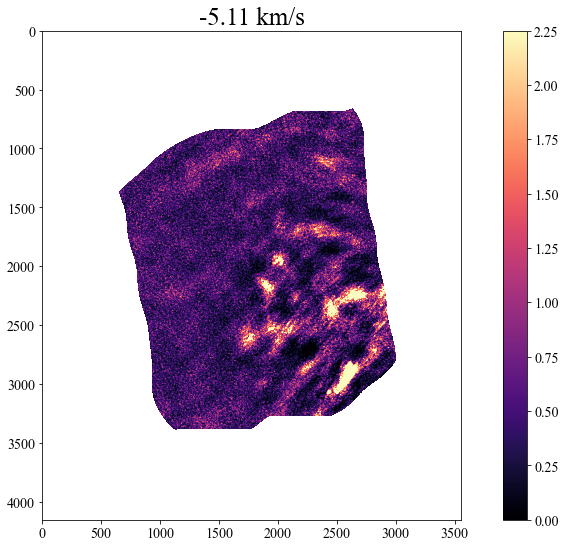

In [18]:
show_usm(im3, -5.11, vmax = 2.25)

# INTEGRATING OVER MULTIPLE VELOCITIES

In [20]:
# over entire range of velocities
all_SS = usm(0, v_indx_max = 111)

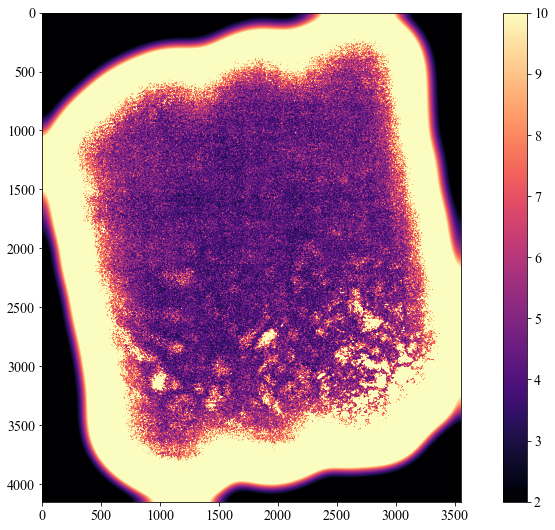

In [29]:
show_usm(all_SS, vmin = 2, vmax = 10)

In [30]:
most_SS = usm(v_indx(1.54 * 10 ** 4), v_indx_max = v_indx(-1.10 * 10 ** 4))

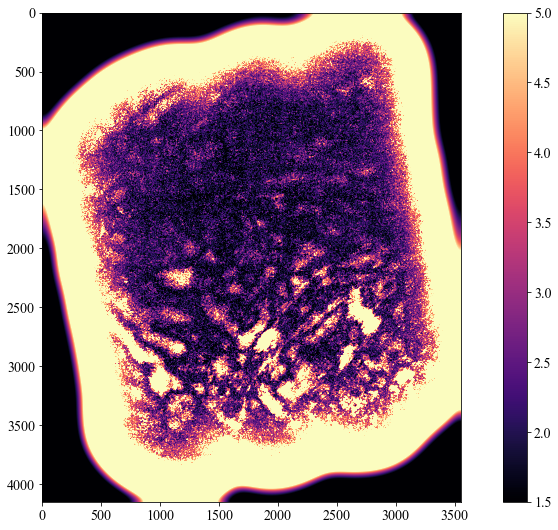

In [36]:
show_usm(most_SS, vmin = 1.5, vmax = 5)

In [37]:
SS1 = usm(v_indx(1.54 * 10 ** 4), v_indx_max = v_indx(4.66 * 10 ** 3))

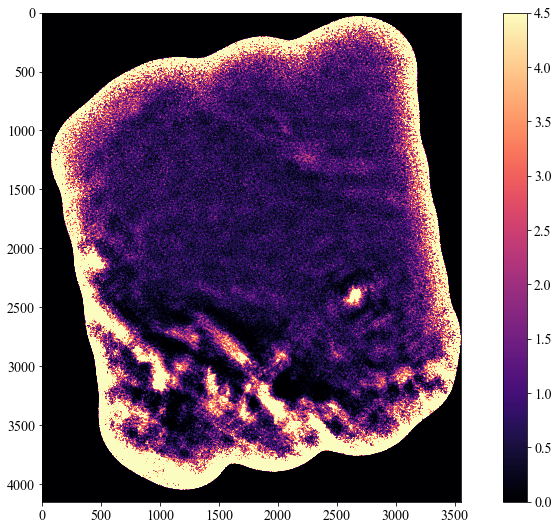

In [44]:
show_usm(SS1, vmax = 4.5)

In [45]:
SS2 = usm(v_indx(4.66 * 10 ** 3), v_indx_max = v_indx(-1.10 * 10 ** 4))

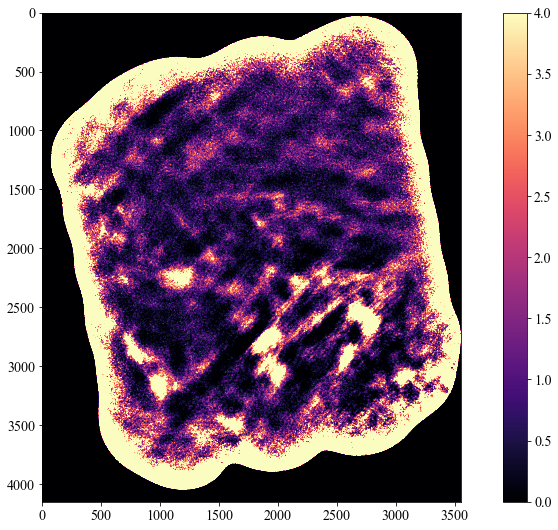

In [47]:
show_usm(SS2, vmax = 4)

# COMPARING BRIGHTNESS TEMPERATURES

In [48]:
# brightness intensity vs velocity for TOTAL cube (over same range of velocities as USM cube)
sum_data = np.nansum(np.nansum(file[0].data[26:56,:,:], axis = 1), axis = 1)

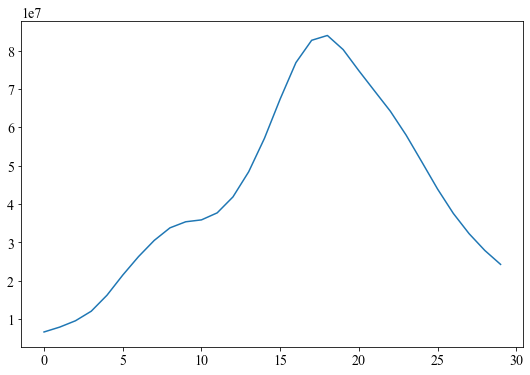

In [49]:
plt.plot(sum_data)

In [50]:
USM_cube = fits.open('/Users/FRANNYPACK/Downloads/grind!/research/Data/MS_USM_cube.fits')

In [51]:
# brightness intensity vs velocity for USM cube 
USM_sum_data = np.nansum(np.nansum(USM_cube[0].data, axis = 1), axis = 1)

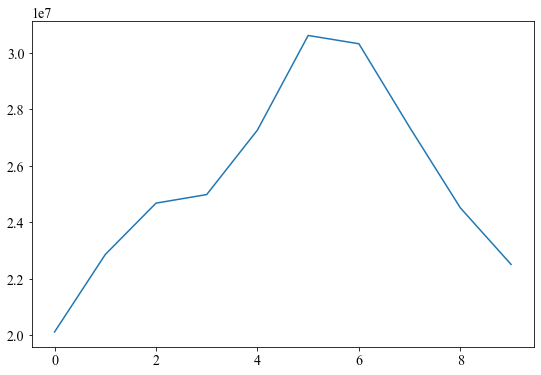

In [52]:
plt.plot(USM_sum_data)